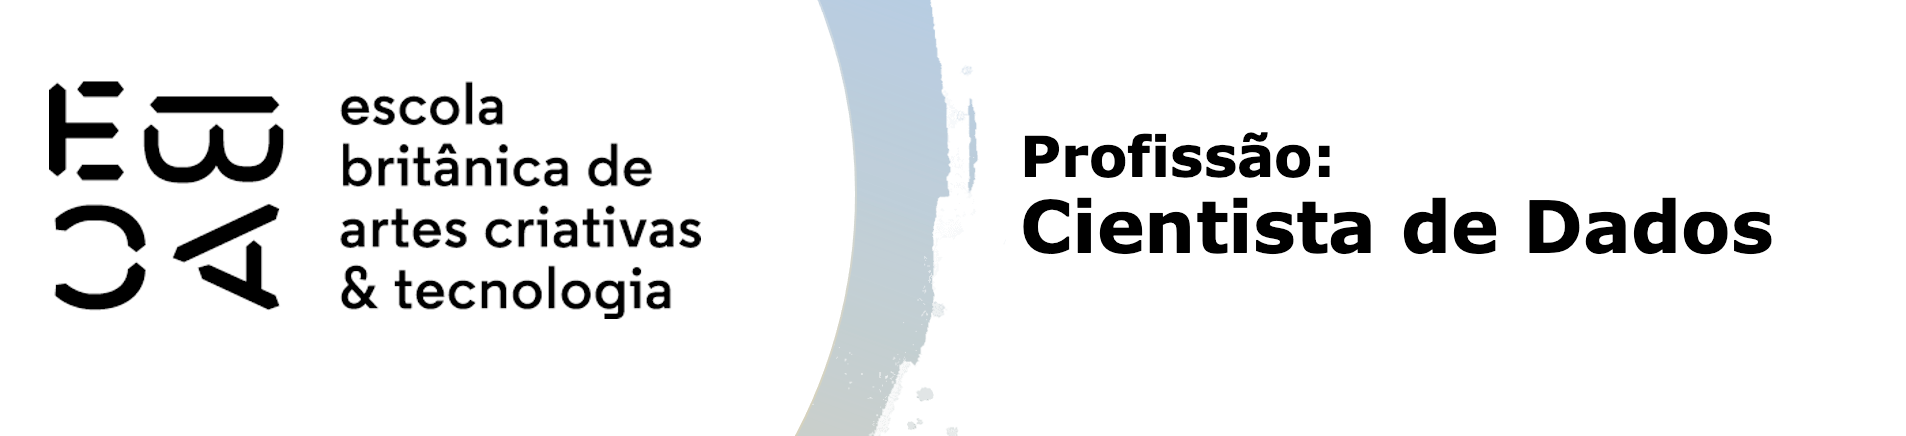

______

## Aluno: Victor Resende

______

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

______

### Dicionário de dados:



| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                | Data de referência de coleta das variáveis          | texto        |
| id_cliente              |  Código de identificação do cliente                 | inteiro      |
| sexo                    |  Sexo do cliente                                    | M/F          |
| posse_de_veiculo        |  Indica se o cliente possui veículo                 | binária      |
| posse_de_imovel         |  Indica se o cliente possui imóvel                  | binária      |
| qtd_filhos              |  Quantidade de filhos do cliente                    | inteiro      |
| tipo_renda              |  Tipo de renda do cliente                           | texto        |
| educacao                |  Grau de instrução do cliente                       | texto        |
| estado_civil            |  Estado civil do cliente                            | texto        |
| tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)| texto        |
| idade                   |  Idade do cliente                                   | texto        |
| tempo_emprego           |  Tempo no emprego atual                             | float        |
| qt_pessoas_residencia   |  Quantidade de pessoas que moram na residência      | float        |
| **renda**               |  Renda em reais                                     | float        |



______

# Regressão III - Tarefa (anterior)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, kstest
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings


In [3]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Valores missing subtituídos pela média

In [5]:
# Verificando valores faltantes:
print(df.isnull().sum())


index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64


In [7]:
# Substituindo valores faltantes na variável 'tempo_emprego' pela média:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

# Exibindo valores faltantes após a substituição:
print("\nValores faltantes após a substituição:")
print(df.isnull().sum())


Valores faltantes após a substituição:
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64


### Base de testes

Três últimos meses como base *holdout* (base de teste).

In [9]:
# Converter o índice para datetime e renomear:
df.index = pd.to_datetime(df.index)
df = df.rename_axis('data_ref')

# Base de holdout: 3 últimos meses:
holdout = df[df.index >= '2015-10-01']
train = df[df.index < '2015-10-01']

# Remover colunas desnecessárias para o modelo:
cols_to_drop = ['index']
x_train = train.drop(columns=cols_to_drop + ['renda'], errors='ignore')
y_train = train['renda']

x_test = holdout.drop(columns=cols_to_drop + ['renda'], errors='ignore')
y_test = holdout['renda']

# Codificar variáveis categóricas (one-hot encoding):
x_train = pd.get_dummies(x_train, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

# Garantir que ambas as bases têm as mesmas colunas:
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

# Padronizar variáveis numéricas:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Primeiro modelo
 Com o $R^2-ajustado$

In [11]:
# Ajustando o modelo de Regressão Linear:
model = LinearRegression()
model.fit(x_train, y_train)

# Predições e avaliação:
y_pred = model.predict(x_test)

# Cálculo do R2 ajustado:
n = x_test.shape[0]  # número de observações
p = x_test.shape[1]  # número de preditores
r2 = r2_score(y_test, y_pred)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R2: {r2:.4f}")
print(f"R2 ajustado: {r2_adjusted:.4f}")

R2: -0.4163
R2 ajustado: -0.4164


### Análise de perfil

Categorização da variável ```tempo_emprego``` em 20 quantis.

Tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Gráfico da média do tempo de emprego pela média do log-renda. 

    tempo_emprego_q  qtd_observacoes  media_log_renda  media_tempo_emprego
0                 0            37699         8.134693             0.515096
1                 1            37522         8.215925             1.124770
2                 2            37437         8.335011             1.783247
3                 3            37391         8.390223             2.513020
4                 4            37915         8.522387             3.300942
5                 5            37253         8.612289             3.989239
6                 6            37401         8.673718             4.613535
7                 7            37545         8.809638             5.367816
8                 8            37495         8.905467             6.205161
9                 9            37379         8.986450             7.010453
10               10           136607         8.815827             7.734515
11               11            13542         9.124771             7.931331
12               12      

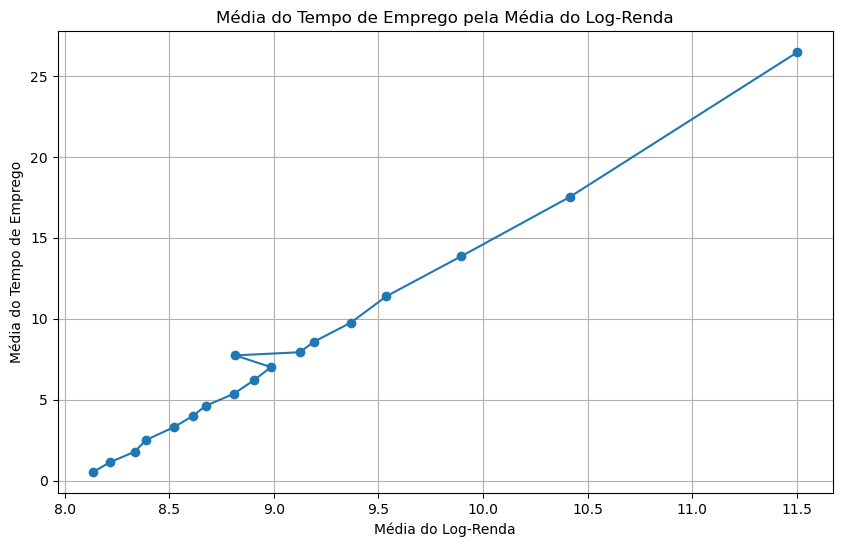

In [13]:
# --- Análise de Perfil ---

# Categorizando tempo_emprego em 20 quantis, lidando com valores duplicados:
df['tempo_emprego_q'] = pd.qcut(df['tempo_emprego'], 20, labels=False, duplicates='drop')

# Remover valores não positivos de renda antes de calcular o log:
df = df[df['renda'] > 0]

# Criando a tabela de perfil:
profile_table = df.groupby('tempo_emprego_q').agg(
    qtd_observacoes=('tempo_emprego', 'count'),
    media_log_renda=('renda', lambda x: np.log(x).mean()),
    media_tempo_emprego=('tempo_emprego', 'mean')
).reset_index()

print(profile_table)

# Gráfico: Média do tempo de emprego pela média do log-renda:
plt.figure(figsize=(10, 6))
plt.plot(profile_table['media_log_renda'], profile_table['media_tempo_emprego'], marker='o', linestyle='-')
plt.title('Média do Tempo de Emprego pela Média do Log-Renda')
plt.xlabel('Média do Log-Renda')
plt.ylabel('Média do Tempo de Emprego')
plt.grid()
plt.show()


### Linearização

- Duas técnicas de linearização: Transformação Logarítmica e Transformação Polinomial, para melhorar o ajuste da variável ```tempo_emprego```. 
- Comparação do $R^2-ajustado$ e avaliação dos resultados relevantes com relação ao primeiro modelo.

Resultados do R² ajustado:
Modelo Original: 0.3929
Modelo com Log(tempo_emprego): 0.3330
Modelo com tempo_emprego²: 0.3933


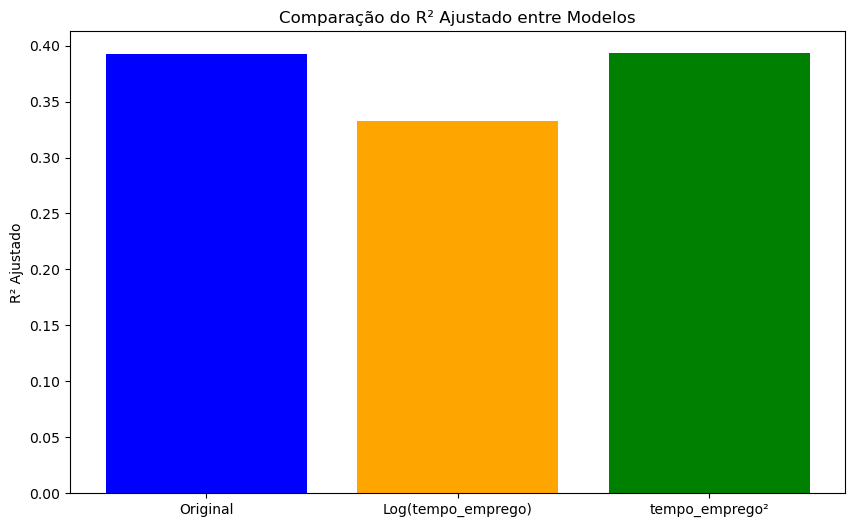

In [15]:
# --- Preparação da base ---
# Removendo colunas que não devem ser usadas:
X = df.drop(columns=['renda', 'index'])  # 'data_ref' já está como índice
X = pd.get_dummies(X, drop_first=True)  # Codificação one-hot
y = np.log(df['renda'])  # Transformação log da variável resposta

# Base treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Função para calcular o R² ajustado:
def calcular_r2_ajustado(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Modelo original (sem transformações):
modelo_original = LinearRegression()
modelo_original.fit(X_train, y_train)
y_pred_original = modelo_original.predict(X_test)
r2_ajustado_original = calcular_r2_ajustado(y_test, y_pred_original, X_test)

# --- Técnica 1: Transformação Logarítmica ---
X_log = X.copy()
X_log['tempo_emprego'] = np.log(X['tempo_emprego'] + 1)

# Reajuste do modelo:
X_train_log, X_test_log, y_train, y_test = train_test_split(X_log, y, test_size=0.3, random_state=42)
modelo_log = LinearRegression()
modelo_log.fit(X_train_log, y_train)
y_pred_log = modelo_log.predict(X_test_log)
r2_ajustado_log = calcular_r2_ajustado(y_test, y_pred_log, X_test_log)

# --- Técnica 2: Transformação Polinomial ---
X_poly = X.copy()
X_poly['tempo_emprego_squared'] = X['tempo_emprego'] ** 2

# Reajuste do modelo:
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)
modelo_poly = LinearRegression()
modelo_poly.fit(X_train_poly, y_train)
y_pred_poly = modelo_poly.predict(X_test_poly)
r2_ajustado_poly = calcular_r2_ajustado(y_test, y_pred_poly, X_test_poly)

# --- Resultados ---
print("Resultados do R² ajustado:")
print(f"Modelo Original: {r2_ajustado_original:.4f}")
print(f"Modelo com Log(tempo_emprego): {r2_ajustado_log:.4f}")
print(f"Modelo com tempo_emprego²: {r2_ajustado_poly:.4f}")

# --- Comparação Visual ---
plt.figure(figsize=(10, 6))
plt.bar(['Original', 'Log(tempo_emprego)', 'tempo_emprego²'], 
        [r2_ajustado_original, r2_ajustado_log, r2_ajustado_poly], color=['blue', 'orange', 'green'])
plt.title('Comparação do R² Ajustado entre Modelos')
plt.ylabel('R² Ajustado')
plt.show()


### Avaliando o modelo


Observações: melhoramos o R² com os modelos e mantivemos a qualidade, conforme verificamos nos gráficos comparativos.


______

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

Avaliação dos Modelos na Base de Testes:
Modelo Original:
  - R² Ajustado: 0.3929
  - RMSE: 0.9996

Modelo com Log(tempo_emprego):
  - R² Ajustado: 0.3330
  - RMSE: 1.0478

Modelo com tempo_emprego²:
  - R² Ajustado: 0.3933
  - RMSE: 0.9993


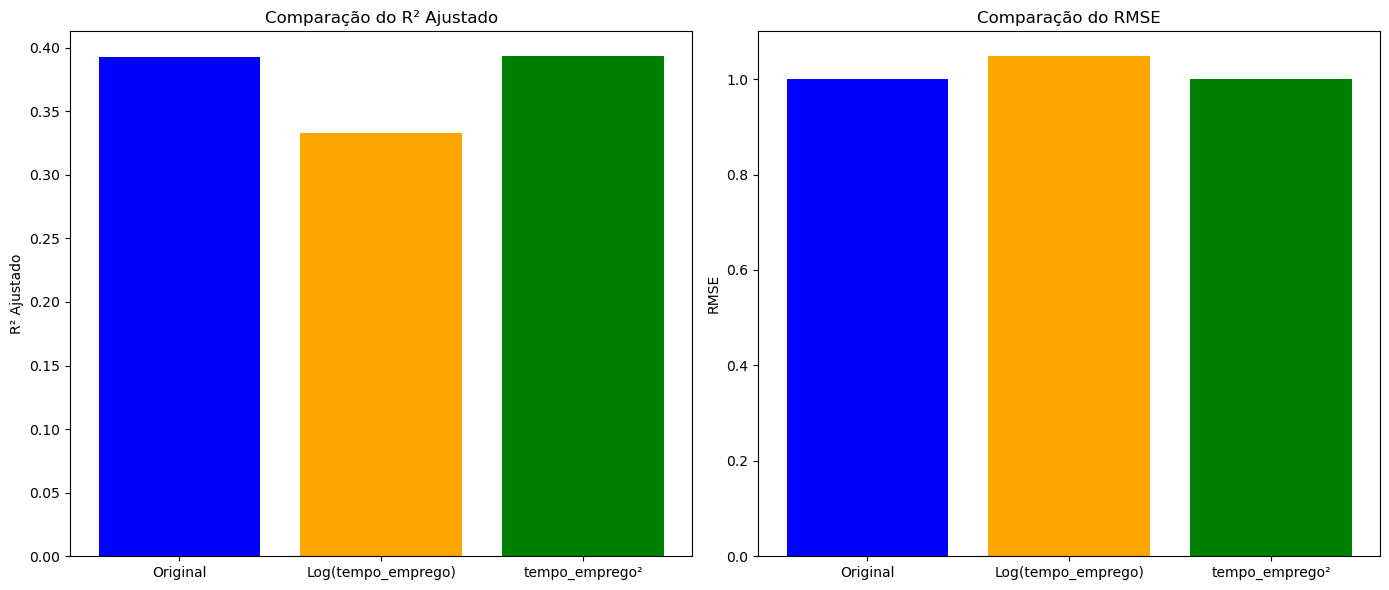

In [17]:
# Função para calcular o R² ajustado:
def calcular_r2_ajustado(y_true, y_pred, X):
    from sklearn.metrics import r2_score
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)  # Número de observações
    p = X.shape[1]   # Número de preditores
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Função para calcular o RMSE:
def calcular_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Avaliação do modelo na base de testes ---
# Modelo Original:
y_pred_original = modelo_original.predict(X_test)
r2_ajustado_original = calcular_r2_ajustado(y_test, y_pred_original, X_test)
rmse_original = calcular_rmse(y_test, y_pred_original)

# Modelo com Log(tempo_emprego):
y_pred_log = modelo_log.predict(X_test_log)
r2_ajustado_log = calcular_r2_ajustado(y_test, y_pred_log, X_test_log)
rmse_log = calcular_rmse(y_test, y_pred_log)

# Modelo com tempo_emprego²:
y_pred_poly = modelo_poly.predict(X_test_poly)
r2_ajustado_poly = calcular_r2_ajustado(y_test, y_pred_poly, X_test_poly)
rmse_poly = calcular_rmse(y_test, y_pred_poly)

# --- Resultados Finais ---
print("Avaliação dos Modelos na Base de Testes:")
print(f"Modelo Original:")
print(f"  - R² Ajustado: {r2_ajustado_original:.4f}")
print(f"  - RMSE: {rmse_original:.4f}")

print(f"\nModelo com Log(tempo_emprego):")
print(f"  - R² Ajustado: {r2_ajustado_log:.4f}")
print(f"  - RMSE: {rmse_log:.4f}")

print(f"\nModelo com tempo_emprego²:")
print(f"  - R² Ajustado: {r2_ajustado_poly:.4f}")
print(f"  - RMSE: {rmse_poly:.4f}")

# --- Comparação Visual ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico R² Ajustado:
ax[0].bar(['Original', 'Log(tempo_emprego)', 'tempo_emprego²'], 
          [r2_ajustado_original, r2_ajustado_log, r2_ajustado_poly], 
          color=['blue', 'orange', 'green'])
ax[0].set_title('Comparação do R² Ajustado')
ax[0].set_ylabel('R² Ajustado')

# Gráfico RMSE:
ax[1].bar(['Original', 'Log(tempo_emprego)', 'tempo_emprego²'], 
          [rmse_original, rmse_log, rmse_poly], 
          color=['blue', 'orange', 'green'])
ax[1].set_title('Comparação do RMSE')
ax[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


____________

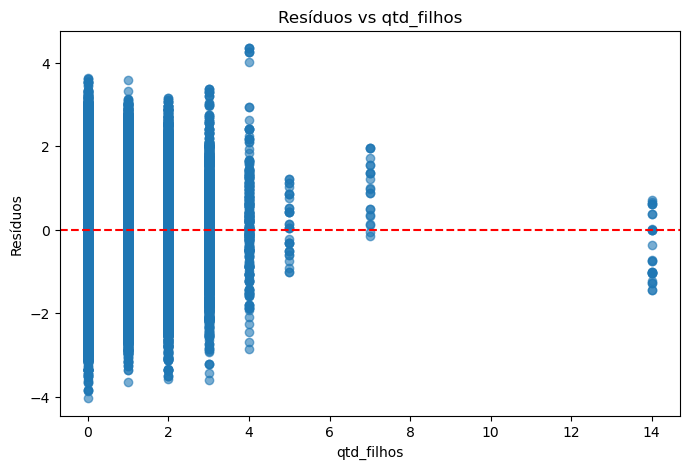

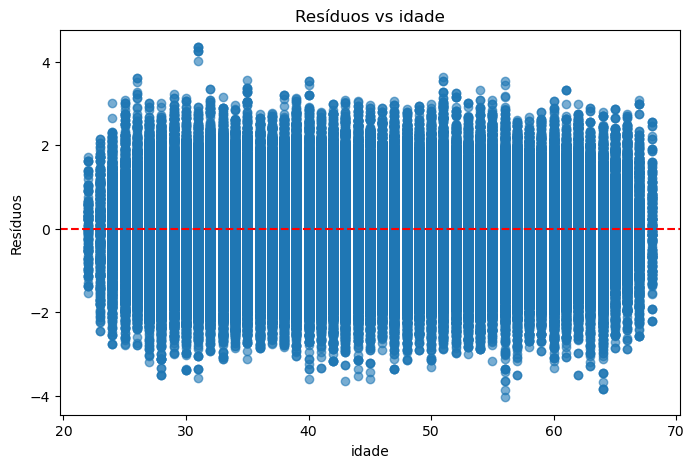

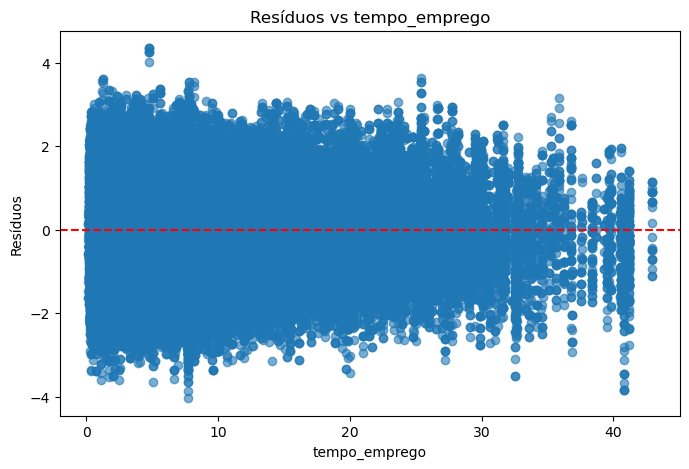

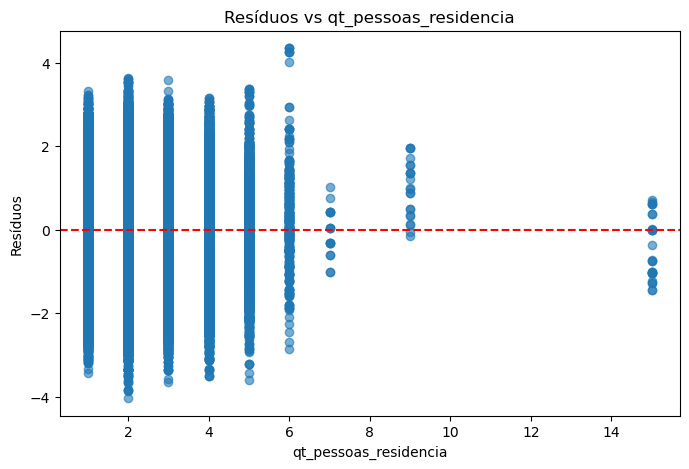

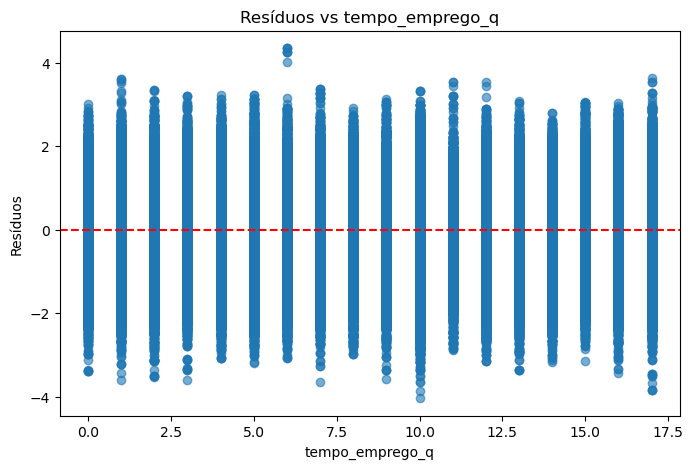

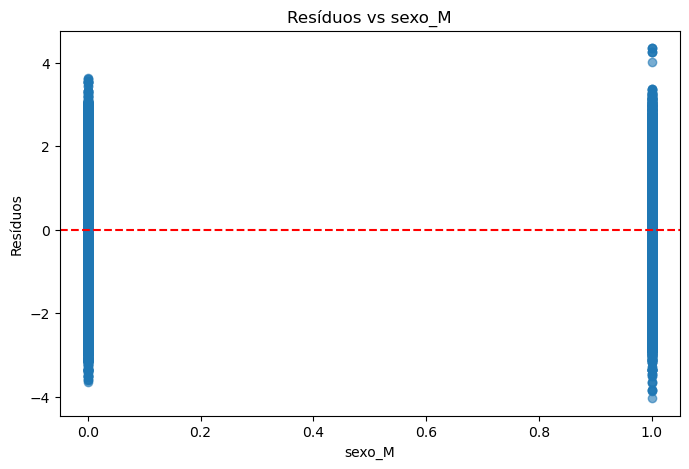

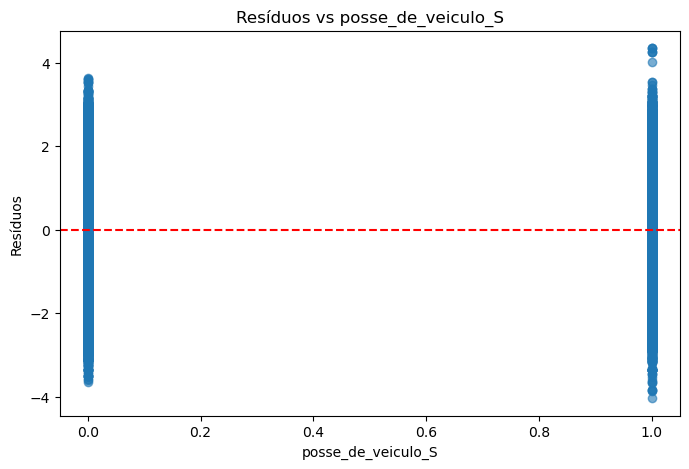

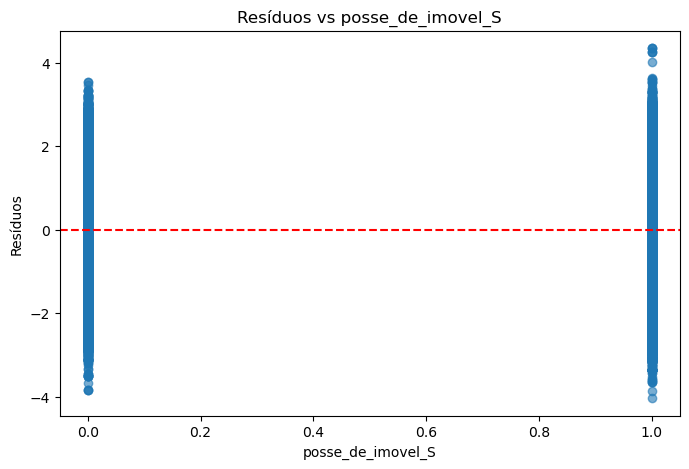

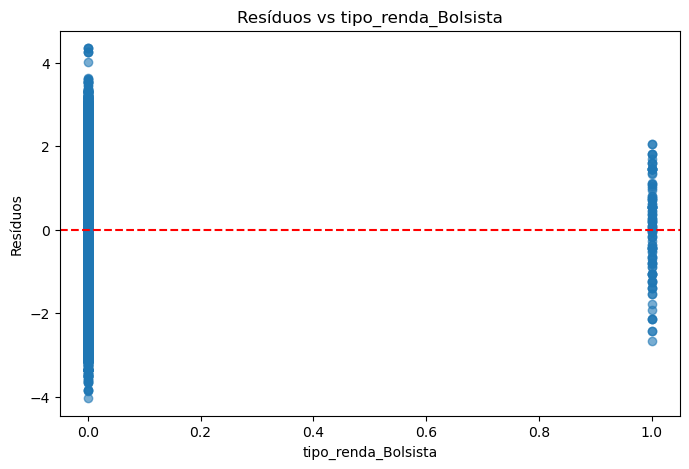

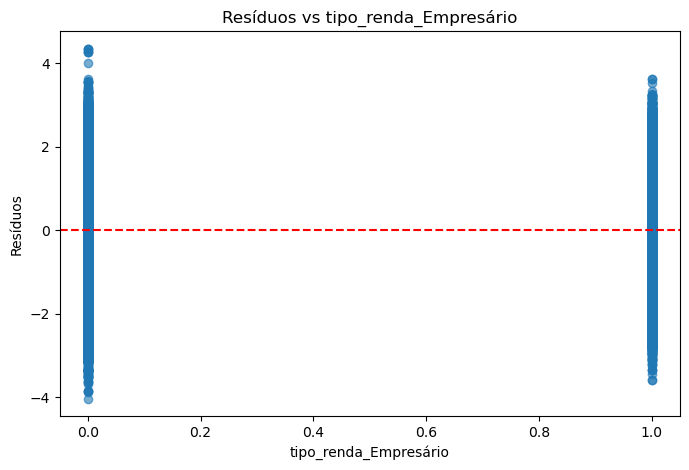

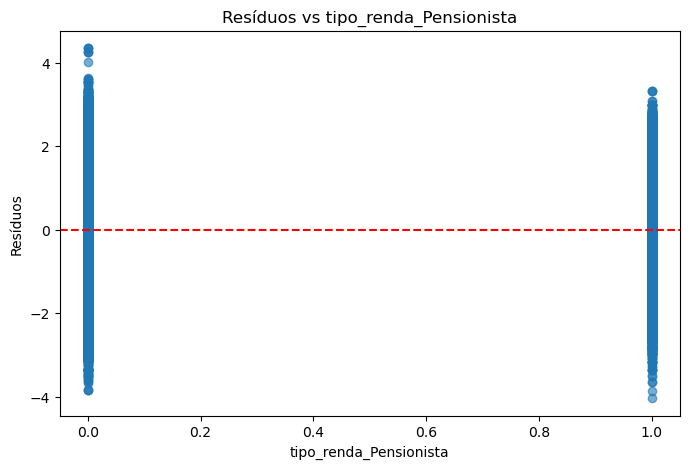

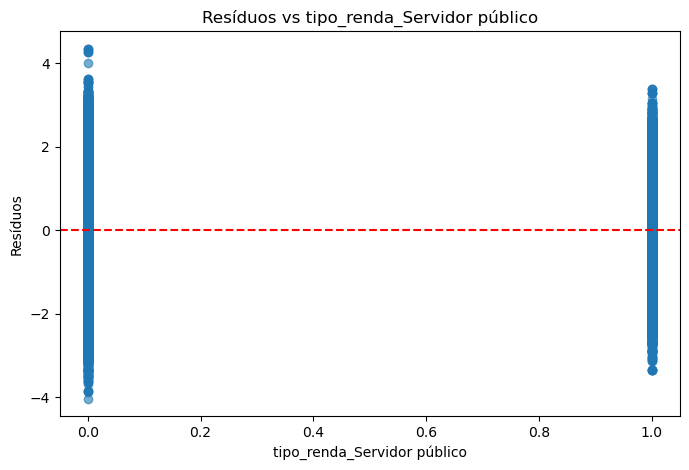

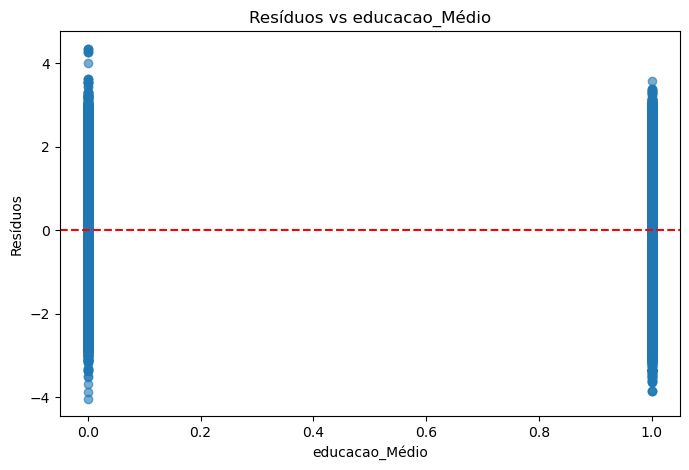

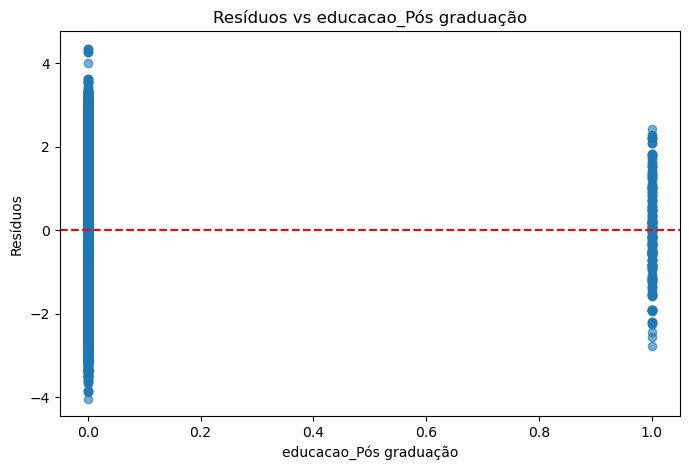

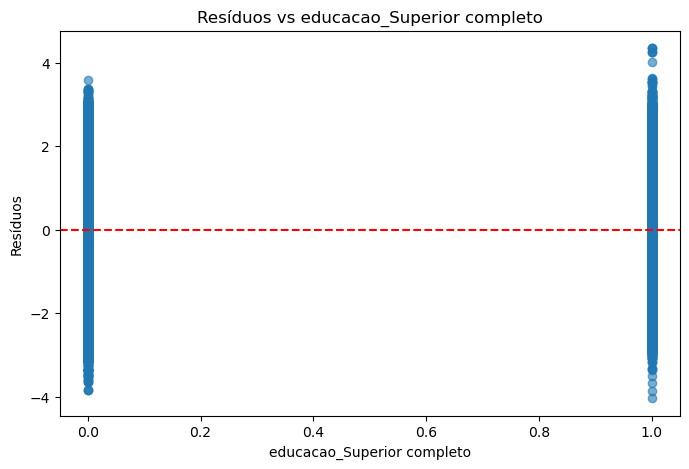

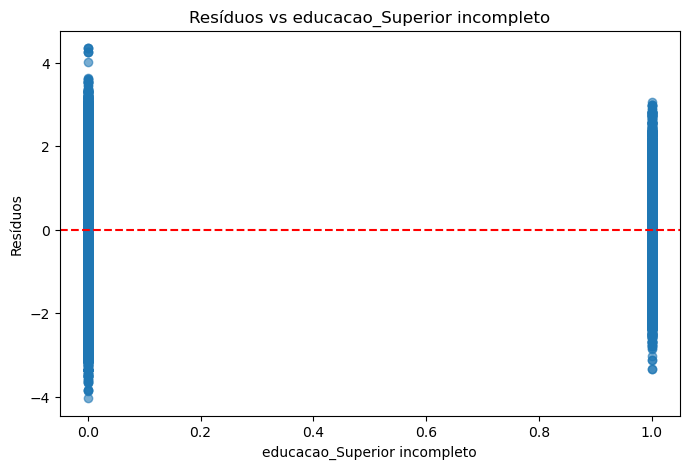

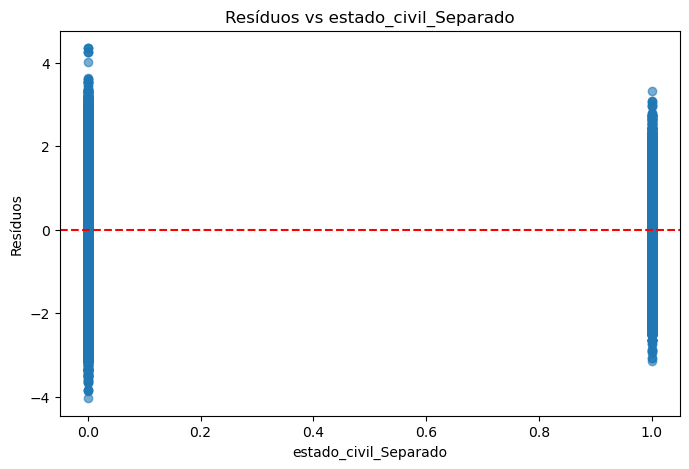

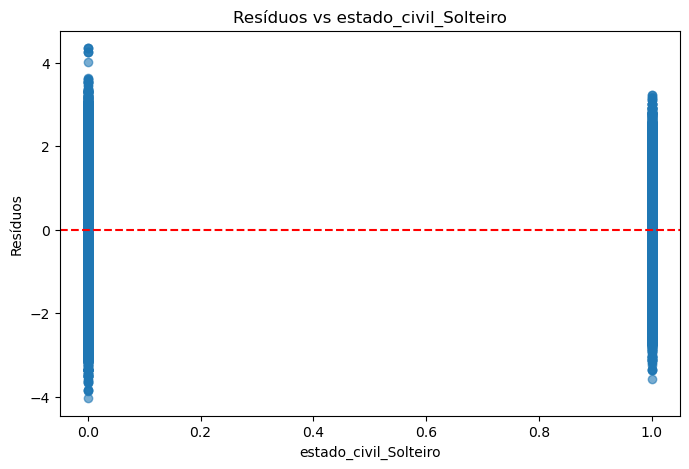

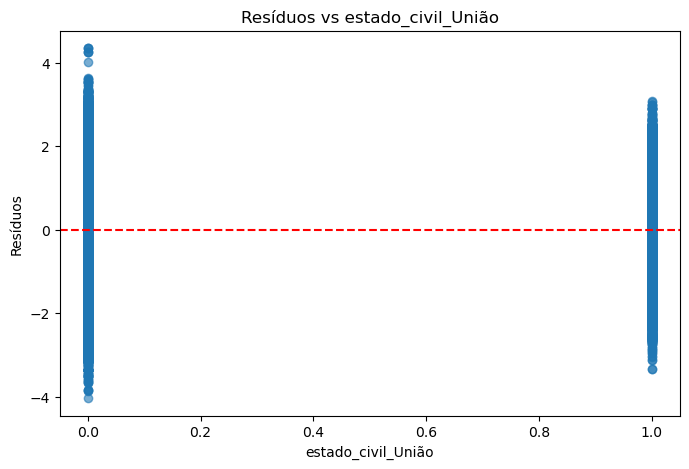

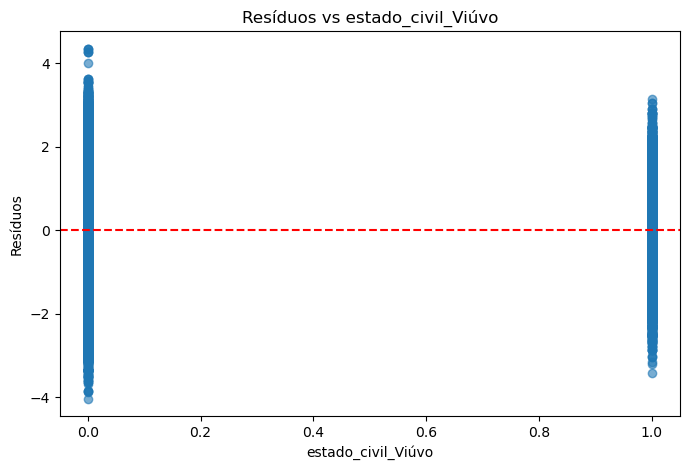

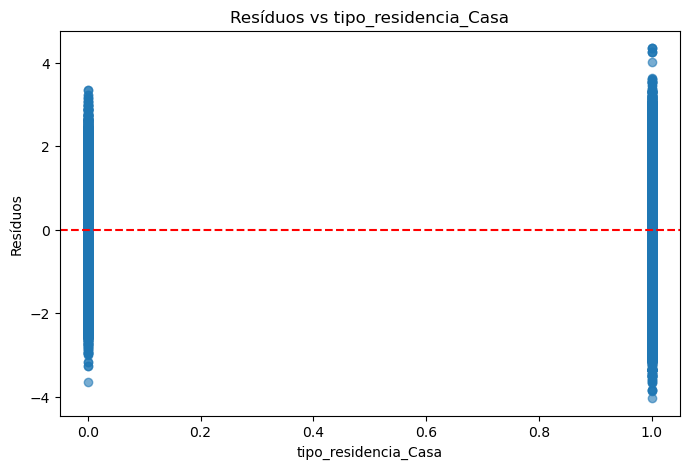

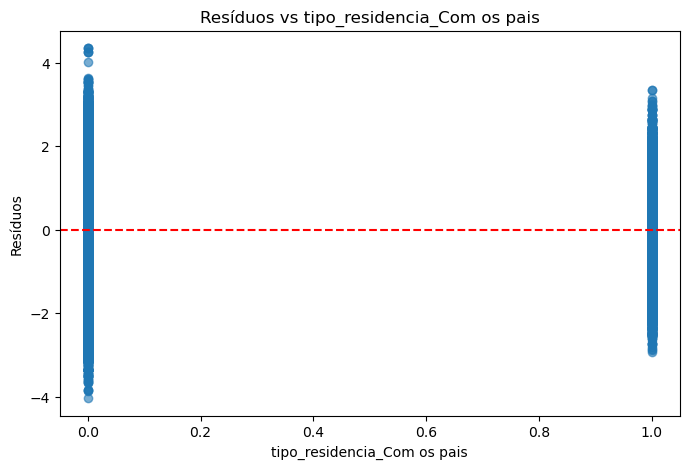

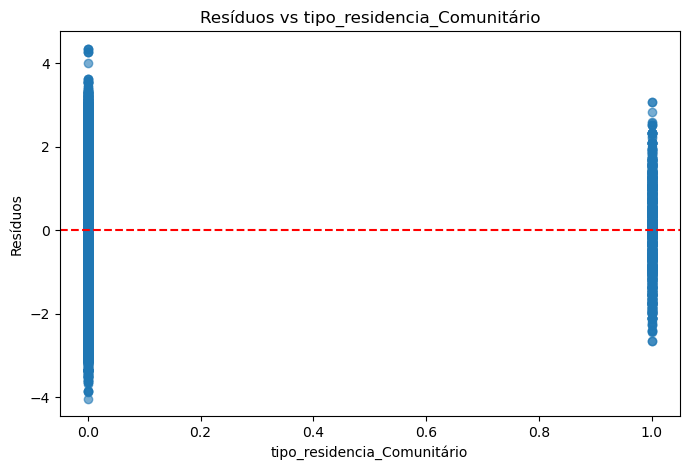

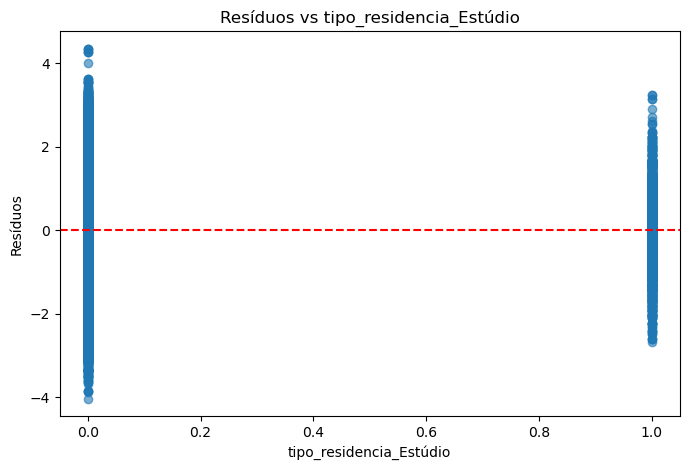

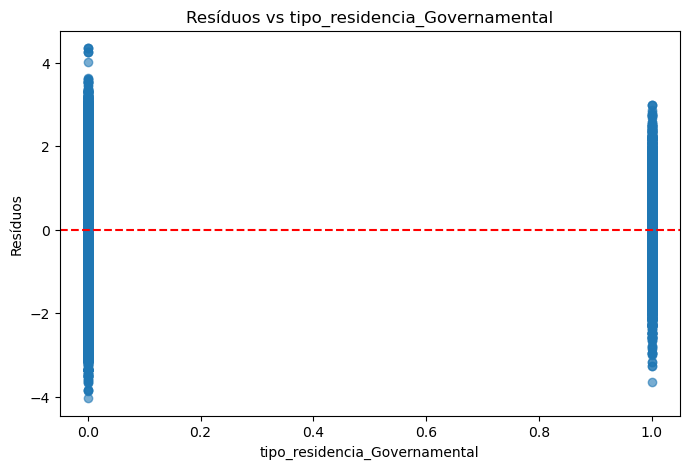

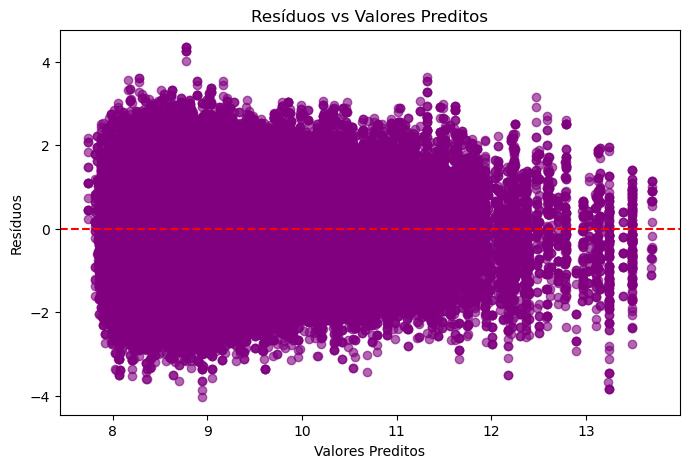

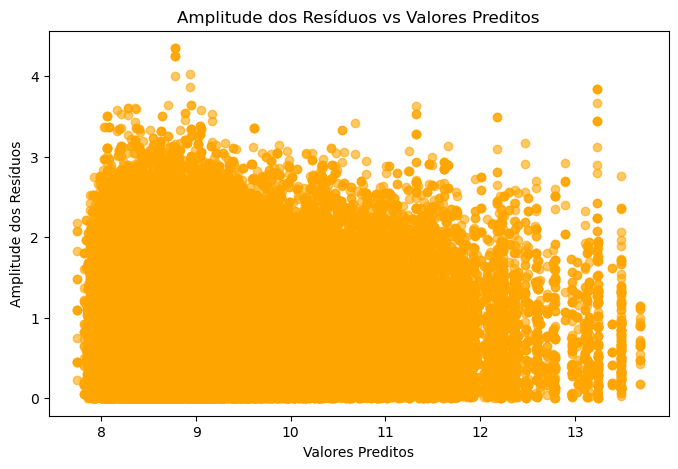

In [19]:
# Calculando os resíduos (diferença entre valores reais e previstos):

residuos = y_test - y_pred_original

# --- 1. Padrões dos resíduos versus cada variável do modelo ---
for coluna in X_test.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(X_test[coluna], residuos, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Resíduos vs {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Resíduos')
    plt.show()

# --- 2. Relação entre o valor médio dos resíduos e o mês de referência ---

if 'mes_referencia' in X_test.columns:
    residuos_df = pd.DataFrame({'mes_referencia': X_test['mes_referencia'], 'residuos': residuos})
    media_residuos_mes = residuos_df.groupby('mes_referencia')['residuos'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=media_residuos_mes, x='mes_referencia', y='residuos', palette="viridis")
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Média dos Resíduos por Mês de Referência')
    plt.xlabel('Mês de Referência')
    plt.ylabel('Média dos Resíduos')
    plt.show()

# --- 3. Variância da variável resposta versus valores previstos ---
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_original, residuos, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()

# Análise de dispersão (heterocedasticidade):
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_original, np.abs(residuos), alpha=0.6, color='orange')
plt.title('Amplitude dos Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Amplitude dos Resíduos')
plt.show()


____________

### <font color='blue'>Temos:

- O valor médio dos resíduos próximo de zero para cada mês.
- A dispersão dos resíduos em torno de zero se apresenta uniforme.
- Verificamos, então, que as suposições foram atendidas.
- Partindo, agora, para a avaliação de outliers e pontos influentes.

____________

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [20]:
# 1. Verifiando os tipos de dados:
print("Tipos de dados antes do ajuste:")
print(df.dtypes)

# 2. Converta para tipos numéricos, se necessário, e trate valores não numéricos
df['renda'] = pd.to_numeric(df['renda'], errors='coerce')  # Convertendo para numérico, valores inválidos se tornam NaN
df['tempo_emprego'] = pd.to_numeric(df['tempo_emprego'], errors='coerce')

# 3. Verifique se há valores ausentes e trate-os (remover ou substituir)
df['renda'] = df['renda'].fillna(0)  # Substituindo valores nulos por 0 na variável renda
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())  # Substituindo valores nulos por média

# 4. Verifique se as variáveis foram tratadas corretamente
print("\nValores de 'renda' após o tratamento:")
print(df['renda'].head())  # Verifique os primeiros valores

print("\nValores de 'tempo_emprego' após o tratamento:")
print(df['tempo_emprego'].head())  # Verifique os primeiros valores

# 5. Verifique novamente os tipos de dados
print("\nTipos de dados após o ajuste:")
print(df.dtypes)

# 6. Se necessário, aplique transformações como np.log
# Aqui, você pode fazer transformações, por exemplo, aplicar logaritmo à variável 'renda'
# Atenção: O logaritmo não pode ser aplicado em valores negativos ou zero
df['renda_log'] = np.log(df['renda'].replace(0, np.nan))  # Substituindo 0 por NaN antes de aplicar log, pois log(0) é indefinido

# 7. Verifique os resultados após a transformação
print("\nPrimeiras linhas após a transformação logaritmica da renda:")
print(df[['renda', 'renda_log']].head())


Tipos de dados antes do ajuste:
index                      int64
sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
tempo_emprego_q            int64
dtype: object

Valores de 'renda' após o tratamento:
data_ref
2015-01-01    11138.14
2015-01-01     2424.81
2015-01-01    13749.66
2015-01-01     2361.84
2015-01-01      790.78
Name: renda, dtype: float64

Valores de 'tempo_emprego' após o tratamento:
data_ref
2015-01-01    16.717808
2015-01-01     9.600000
2015-01-01     8.208219
2015-01-01     1.301370
2015-01-01     1.254795
Name: tempo_emprego, dtype: float64

Tipos de dados após o ajuste:
index                      int64
sexo                     

Pontos discrepantes (resíduos studentizados > 3): [   943   1066   1621   3015   5430   6908   7153   8335   8872   9873
  10090  10273  12743  12766  12950  13027  13083  14168  14874  15128
  15303  15663  15684  15788  16359  16945  17063  17103  17326  17865
  19548  20023  20399  21119  21262  21906  23353  24702  25600  25925
  27173  28246  29329  30305  30382  32134  32540  33162  33176  33497
  33645  35077  35618  36315  37832  38464  38764  39189  39991  40039
  40784  41030  41334  44258  44699  45610  46189  47184  47975  48011
  49046  52598  53423  54904  55500  57175  57546  61932  66185  67659
  71969  75020  75141  77000  81706  82317  83974  84234  84349  84407
  88143  93846  94553  96523  96643  96950  97578 101273 107349 108984
 109227 109506 110748 118980 126610 127770 128201 135275 147540 177660
 178773 186609 193706 201765 204601 204730 205850 207006 207157 209473
 211576 211763 213524 216095 216428 217843 219640 220401 221478 228569
 228623 229074 230890 23146

C:\Users\User\AppData\Local\Temp\ipykernel_6032\766115217.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


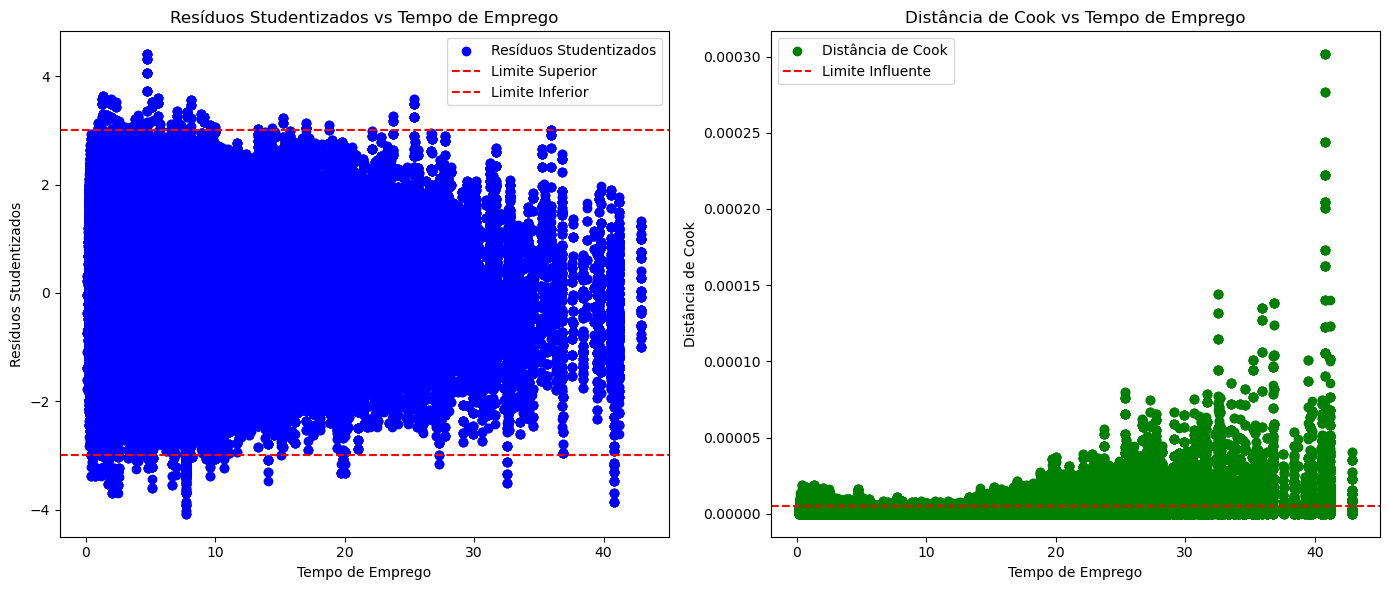

In [23]:
# Ajustando o modelo de regressão linear
# Supondo que a variável resposta seja 'renda' e a variável preditora seja 'tempo_emprego'
X = sm.add_constant(df['tempo_emprego'])  # Adiciona a constante (intercepto)
y = df['renda_log']  # A variável resposta é 'renda_log' (logaritmo de 'renda')

# Ajuste do modelo de regressão linear
model = sm.OLS(y, X).fit()

# Obtendo os resíduos studentizados
studentized_residuals = model.get_influence().resid_studentized_internal

# Identificando pontos discrepantes (valores absolutos dos resíduos studentizados > 3)
discrepant_points = np.where(np.abs(studentized_residuals) > 3)[0]

# Cálculo da distância de Cook
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]

# Identificando pontos influentes (distância de Cook > 4/n)
n = len(df)  # Número de observações
influential_points = np.where(cooks_distance > 4/n)[0]

# Exibindo os resultados
print(f"Pontos discrepantes (resíduos studentizados > 3): {discrepant_points}")
print(f"Pontos influentes (distância de Cook > 4/n): {influential_points}")

# Gráficos
plt.figure(figsize=(14, 6))

# Gráfico dos resíduos studentizados
plt.subplot(1, 2, 1)
plt.scatter(df['tempo_emprego'], studentized_residuals, color='blue', label='Resíduos Studentizados')
plt.axhline(y=3, color='red', linestyle='--', label='Limite Superior')
plt.axhline(y=-3, color='red', linestyle='--', label='Limite Inferior')
plt.xlabel('Tempo de Emprego')
plt.ylabel('Resíduos Studentizados')
plt.title('Resíduos Studentizados vs Tempo de Emprego')
plt.legend()

# Gráfico da distância de Cook
plt.subplot(1, 2, 2)
plt.scatter(df['tempo_emprego'], cooks_distance, color='green', label='Distância de Cook')
plt.axhline(y=4/n, color='red', linestyle='--', label='Limite Influente')
plt.xlabel('Tempo de Emprego')
plt.ylabel('Distância de Cook')
plt.title('Distância de Cook vs Tempo de Emprego')
plt.legend()

plt.tight_layout()
plt.show()


____________

### <font color='red'>Explicação:

- Cálculo dos resíduos estudantis : ajudam a identificar pontos que têm uma exclusão maior que seria esperada, considerando a variabilidade do modelo ajustado.

- Identificação de pontos discrepantes : utilizamos os resíduos estudantis para encontrar pontos que possuam valores altos, ou que indiquem discrepâncias em relação ao modelo.

- Avaliação de pontos influentes : foi utilizado, aqui, a distância de Cook para identificar pontos que tenham grande influência na avaliação dos coeficientes do modelo.

- Verificamos, por exemplo, alguns outliers na variável tempo_emprego, conforme o gráfico <font color='blue'>Distância de Cook vs Tempo de Emprego<font color>.

- Verificamos alguns resíduos, pontos discrepantes, conforme o gráfico <font color='blue'>Resíduos Studentizados vs Tempo de Emprego<font color>. 


____________

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


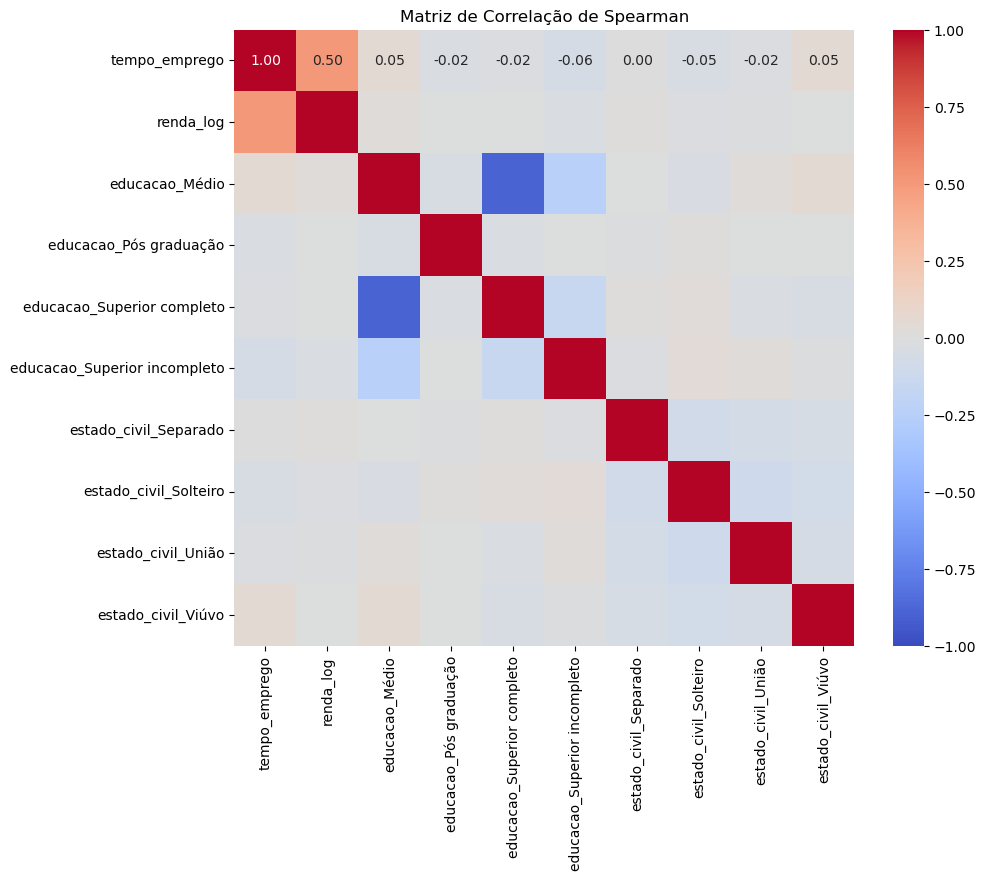

VIF (Variance Inflation Factor) para cada variável:
                        Variable         VIF
0                          const  150.625462
1                  tempo_emprego    1.608623
2                      renda_log    1.604324
3                 educacao_Médio   21.556196
4         educacao_Pós graduação    1.093170
5     educacao_Superior completo   20.679897
6   educacao_Superior incompleto    4.291070
7          estado_civil_Separado    1.020150
8          estado_civil_Solteiro    1.032990
9             estado_civil_União    1.025549
10            estado_civil_Viúvo    1.018427


In [25]:
# Garantir que o índice seja único no dataframe original
df = df.reset_index(drop=True)

# 1. Codificação One-Hot para variáveis categóricas
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_columns = encoder.fit_transform(df[['educacao', 'estado_civil']])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['educacao', 'estado_civil']))

# Garantir que o índice de encoded_df coincida com o índice do dataframe original
encoded_df.index = df.index

# 2. Juntando as colunas codificadas ao dataframe original
df_encoded = pd.concat([df.drop(['educacao', 'estado_civil'], axis=1), encoded_df], axis=1)

# 3. Tratar valores nulos: substituindo por média para variáveis numéricas
df_encoded.fillna(df_encoded.mean(numeric_only=True), inplace=True)

# 4. Seleção das variáveis de interesse
selected_columns = ['tempo_emprego', 'renda_log'] + list(encoded_df.columns)
X = df_encoded[selected_columns]

# 5. Verificar e tratar valores não numéricos ou infinitos
X = X.apply(pd.to_numeric, errors='coerce')
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# 6. Matriz de Correlação de Spearman
correlation_matrix = X.corr(method='spearman')

# Plotando a matriz de correlação de Spearman
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Spearman')
plt.show()

# 7. Cálculo do VIF (Variance Inflation Factor)
X_with_const = sm.add_constant(X)

# Calculando o VIF
vif_data = pd.DataFrame({
    "Variable": X_with_const.columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
})

# Exibindo o VIF
print("VIF (Variance Inflation Factor) para cada variável:")
print(vif_data)


____________

### <font color='red'>Avaliação:

- Constatamos a forte correlação entre as variáveis <font color='blue'>renda <font color='black'>e <font color='blue'>tempo_emprego <font color='black'>.

- Esse resultado nos ajuda e prever nosso modelo e destacar as referidas variáveis para o cálculo para a previsão de renda.

- De acordo com os resultados, acima, temos as variáveis sobre <font color='red'>tipo de educação <font color='black'>, que também podem nos auxiliar em nosso processo de previsão de renda.

____________

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


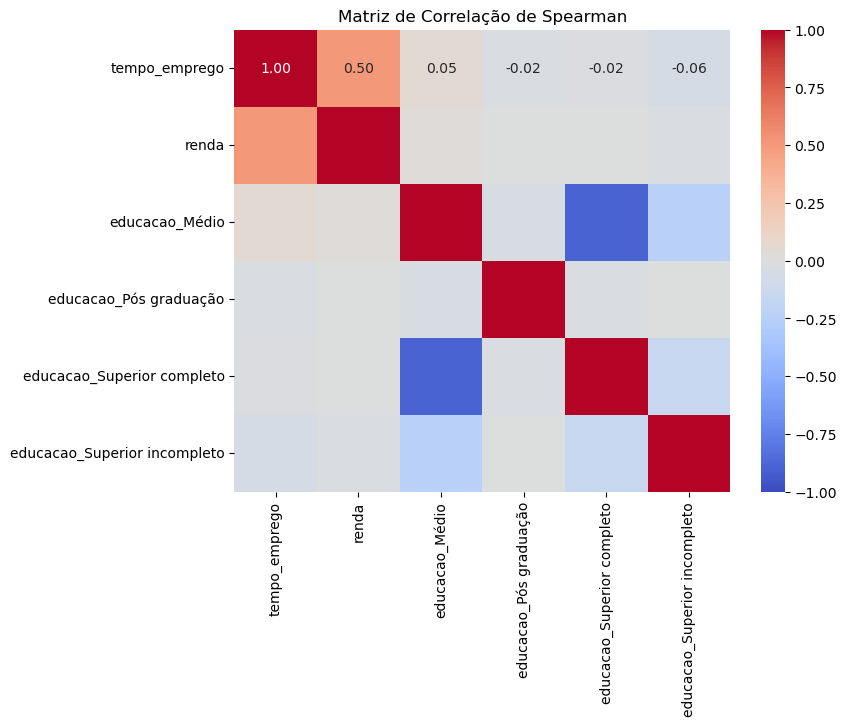

VIF (Variance Inflation Factor) para cada variável:
                       Variable        VIF
0                         const  89.246918
1                 tempo_emprego   1.271011
2                         renda   1.267314
3                educacao_Médio  21.551491
4        educacao_Pós graduação   1.092857
5    educacao_Superior completo  20.671473
6  educacao_Superior incompleto   4.288301


In [29]:
# 1. Codificação One-Hot para variáveis categóricas (educacao)
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_columns = encoder.fit_transform(df[['educacao']])

# Criar DataFrame com as colunas codificadas
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['educacao']))

# 2. Substituição de NaN apenas nas variáveis numéricas
df_encoded = pd.concat([df[['tempo_emprego', 'renda']].reset_index(drop=True), encoded_df], axis=1)
df_encoded.fillna(df_encoded.select_dtypes(include=[np.number]).mean(), inplace=True)

# 3. Seleção das variáveis mais relevantes para o modelo
selected_columns = ['tempo_emprego', 'renda'] + [col for col in encoded_df.columns if 'educacao' in col]
X = df_encoded[selected_columns]

# 4. Verificar e tratar valores não numéricos ou infinitos
X = X.apply(pd.to_numeric, errors='coerce')  # Coerção de valores não numéricos para NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Substituir infinitos por NaN
X.dropna(inplace=True)  # Remover linhas com NaN

# 5. Calcular a matriz de correlação de Spearman
correlation_matrix = X.corr(method='spearman')

# Plotando a matriz de correlação de Spearman
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Spearman')
plt.show()

# 6. Cálculo do VIF (Variance Inflation Factor)
X_with_const = sm.add_constant(X)  # Adicionando constante para cálculo do VIF

# Calculando o VIF
vif_data = pd.DataFrame({
    "Variable": X_with_const.columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
})

# Exibindo o VIF para cada variável
print("VIF (Variance Inflation Factor) para cada variável:")
print(vif_data)


_____________

### <font color='red'>Conclusão:

- Com os ajustes, utilizando as mesmas variáveis acima apuradas, mantemos o nosso modelo para o melhor desempenho de previsão de renda, levando em consideração a variáveis <font color='blue'>renda <font color='black'>e <font color='blue'>tempo_emprego <font color='black'>.

_____